## librerias

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [4]:
%run codigos/R_Fresnel.ipynb
%run codigos/mv_to_ep.ipynb

## Parametros globales de la antena

In [5]:
#-----------------------------------
## Parámetros globales de la antena
#-----------------------------------

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 
corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

#------------------------------
##Elegir frecuencia portadora
#------------------------------
portadora = input('portadora? (Fc7 o Fc8)')

if portadora == 'Fc7':
    fc = 7.290e9 
    Fc = '7.29GHz'
elif portadora == 'Fc8':
    fc = 8.748e9
    Fc = '8.74GHz'
else:
    print('Error: portadora debe ser Fc7 o Fc8')

In [6]:
#------------------------------
##Elegir fecha de mediciones
#------------------------------
mes = input('mes? (mayo, junio, julio o agosto)')

with open('Mediciones/'+mes+'_'+portadora+'.pkl','rb') as g:
    Med = pickle.load(g)
print(Med.keys())
with open('Mediciones/hydra_'+mes+'.pkl','rb') as gg:
    hydra = pickle.load(gg)
print(hydra.keys())

dict_keys(['h_ag', 'f_ag', 'S1A_ag', 'S1B_ag', 'S2_ag', 'M2_ag', 'hz_ag', 'Z2_ag', 'MZ2_ag', 'tita_ag'])
dict_keys(['depth_ag', 'mv_med_ag', 'ep_med_ag', 'sigma_ag'])


## Parametros del suelo

In [7]:
hydraList = list(hydra.keys())

depth = hydra.get(hydraList[0])
mv_med = hydra.get(hydraList[1])
ep_med = hydra.get(hydraList[2])
sigma = hydra.get(hydraList[3])

In [8]:
#grilla de valores para MV
mv_min = 0*np.min(mv_med)
mv_max = 1.25*np.max(mv_med)
n_mv = 100
MV = np.linspace(mv_min,mv_max,n_mv)

Sand = 0.4
Clay = 0.6

ep_teo = mv_to_ep(MV,Sand,Clay,0)['ep']

#usando el error
#ep_std = 0.01 #std para estimar el error en ep del modelo teórico
#ep_teo = mv_to_ep(MV,Sand,Clay,ep_std)['ep']
#ep_error = mod.mv_to_ep(MV,Sand, Clay,ep_std)['ep_error']

ep_min, ep_max = np.min(ep_teo), np.max(ep_teo)
# print('ep min:', ep_min)
# print('ep max:', ep_max)

n_ep = 20
ep1Range = np.linspace(ep_min,0.7*ep_max,n_ep)
ep2Range = np.linspace(1.15*ep_min,0.95*ep_max,n_ep)
print('ep1:',ep1Range[0],ep1Range[-1])
print('ep2:',ep2Range[0],ep2Range[-1])

# espesor de la capa
d_min, d_max, n_d = 0.010, 0.08, 40
dRange = np.linspace(d_min,d_max,n_d)

print('d:',np.min(dRange),np.max(dRange))

ep1: (2.0086-0.198j) (8.854474693750001+2.148034196875j)
ep2: (2.3098899999999998-0.22769999999999999j) (12.016787084375+2.9151892671875j)
d: 0.01 0.08


### Parametros de rugosidad del suelo (rms)

In [9]:
rms1Range = np.linspace(0,1,n_ep)
rms2Range = np.linspace(0,1,n_ep)

# Mediciones S1 vs S2

In [10]:
#if portadora == 'Fc8':
keysList = list(Med.keys())
if mes == 'agosto':
    h1 = Med.get(keysList[0])
    h2 = h1
    f = Med.get(keysList[1])
    S1 = Med.get(keysList[2])
    S2 = Med.get(keysList[4])
    S1B = Med.get(keysList[3])
else:
    h1 = Med.get(keysList[0])
    h2 = Med.get(keysList[1])
    f = Med.get(keysList[2])
    S1 = Med.get(keysList[3])
    S2 = Med.get(keysList[4])
    
#else:
    #print('las mediciones d efrecuencia 7 no estan pickleadas')
    # keylist = list(Med7.keys())
    # if mes == agosto:
    #     h1 = Med.get(keysList[0])
    #     h2 = h1
    #     f = Med.get(keysList[1])
    #     S1 = Med.get(keysList[2])
    #     S2 = Med.get(keysList[4])
    #     S1B = Med.get(keysList[3])
    # else:
    #     h1 = Med.get(keysList[0])
    #     h2 = Med.get(keysList[1])
    #     f = Med.get(keysList[2])
    #     S1 = Med.get(keysList[3])
    #     S2 = Med.get(keysList[4])


## Modelo rugoso

### Dos capas
<!-- \epsilon_0
~~~~~~~~~~~~~
\epsilon_1
~~~~~~~~~~~~~
\epsilon_2 -->



Seguimos el modelo del paper "Degree of roughness of rough layers" - pinel (2010)

\begin{equation}
<E_t>=<E_{r1}>+<E_{r2}>
\end{equation}

\begin{cases}
<E_{r1}>=R_{01}E_ie^{-2k_{0z}^2\sigma_a^2}\\
<E_{r2}>=T_{01}R_{12}T_{10}E_ie^{i2k_{1z}d}e^{-(k_{0z}-k_{1z})^2\sigma_a^2}e^{-k_{1z}^2\sigma_b^2}
\end{cases}

donde

$d$ es el ancho de la capa

$R_{ij}$ y $T_{ij}$ son los coeficienes de reflexion de fresnel

$k_{0z}=\frac{2\pi f}{c}\sqrt{\epsilon_0}cos(\theta_i)$ (obs: aire $\epsilon_0=1$)

$k_{1z}=\frac{2\pi f}{c}\sqrt{\epsilon_1}cos(\theta_t)$ con $cos(\theta_t)=\sqrt{1-\frac{\epsilon_i}{\epsilon_j}sen^2(\theta_i)}$

$\sigma_a$ y $\sigma_b$ son la altura RMS (root mean square) de las capas

In [11]:
def Rf_2(ep1,ep2,d,tita,f,rms1,rms2):
    #---------coef fresnel-----------
    #por snell
    tita_1 = np.arcsin(np.sin(tita)/np.sqrt(ep1))

    R01 = R_ij(1,ep1,tita, tita_1)
    T01 = T_ij(1,ep1,tita,tita_1)
    T10 = T_ij(ep1,1,tita_1,tita)

    #por snell
    tita_2 = np.arcsin(np.sqrt(ep1/ep2)*np.sin(tita_1))
    R12 = R_ij(ep1,ep2,tita_1,tita_2)
    #--------------------------------

    #--------kiz---------------------
    k0z = (2*np.pi*f*np.cos(tita))/3e8
    k1z = (2*np.pi*f+np.sqrt(ep1)*np.cos(tita_1))/3e8
    #--------------------------------

    Rf1 = R01*np.exp(-2*k0z**2*rms1**2)
    Rf2 = T01*R12*T10*np.exp(2*1j*k1z*d)*np.exp(-(k0z-k1z)**2*rms1**2)*np.exp(-2*k1z**2*rms2**2)
    Rft = Rf1+Rf2
    return Rft



In [12]:
# vector para guardar el error
Errores = np.zeros((n_d,n_ep,n_ep,n_ep,n_ep),dtype=float)

# vector en donde guardo la señal teórica que mejor ajusta a cada medición
D_opt = np.zeros(len(h1), dtype=float)
EP1_opt = np.zeros(len(h1), dtype=complex)
EP2_opt = np.zeros(len(h1), dtype=complex)
RMS1_opt = np.zeros(len(h1), dtype=float)
RMS2_opt = np.zeros(len(h1), dtype=float)

plt.figure()
for i in range(len(h1)):
    for i0 in range(n_d):
        D = dRange[i0]
        for i1 in range(n_ep):
            EP1 = ep1Range[i1]
            for i2 in range(n_ep):
                EP2 = ep2Range[i2]
                for i3 in range(n_ep):
                    RMS1 = rms1Range[i3]
                    for i4 in range(n_ep):
                        RMS2 = rms2Range[i4]

                        # coef rugosidad
                        R = Rf_2(EP1,EP2,D,0,f,RMS1,RMS2)
                        S2_teo = S1B[i]*R
                
                        ## Calculo métricas de error #
                        Errores[i0,i1,i2,i3,i4] = np.sum(np.abs(np.abs(S2_teo)-np.abs(S2[i])))/len(S2_teo)  ## error absoluto medio
    print('altura: h = ',h1[i])
    print('indices optimos:', np.unravel_index(Errores.argmin(),Errores.shape))

    indice_d_opt = np.unravel_index(Errores.argmin(),Errores.shape)[0]
    D_opt[i] = dRange[indice_d_opt]

    indice_ep1_opt = np.unravel_index(Errores.argmin(),Errores.shape)[1]
    EP1_opt[i] = ep1Range[indice_ep1_opt]

    indice_ep2_opt = np.unravel_index(Errores.argmin(),Errores.shape)[2]
    EP2_opt[i] = ep2Range[indice_ep2_opt]

    indice_rms1_opt = np.unravel_index(Errores.argmin(),Errores.shape)[3]
    RMS1_opt[i] = ep2Range[indice_rms1_opt]

    indice_rms2_opt = np.unravel_index(Errores.argmin(),Errores.shape)[4]
    RMS2_opt[i] = ep2Range[indice_rms2_opt]



altura: h =  0.355
indices optimos: (0, 19, 1, 19, 0)


<ipython-input-12-899d68f1c91b>:43: ComplexWarning: Casting complex values to real discards the imaginary part
  RMS1_opt[i] = ep2Range[indice_rms1_opt]
<ipython-input-12-899d68f1c91b>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  RMS2_opt[i] = ep2Range[indice_rms2_opt]


altura: h =  0.435
indices optimos: (0, 8, 1, 0, 18)


<Figure size 432x288 with 0 Axes>

In [13]:
id_opt_agostoB = {
    'D_opt' : D_opt,
    'EP1_opt' : EP1_opt,
    'EP2_opt' : EP2_opt,
    'RMS1_opt' : RMS1_opt,
    'RMS2_opt' : RMS2_opt
}

pkl = open("Mediciones/id_opt_agostoB.pkl","wb") #Wb : write binary
pickle.dump(id_opt_agostoB,pkl) # write the python object (dict) to pickle file
pkl.close()

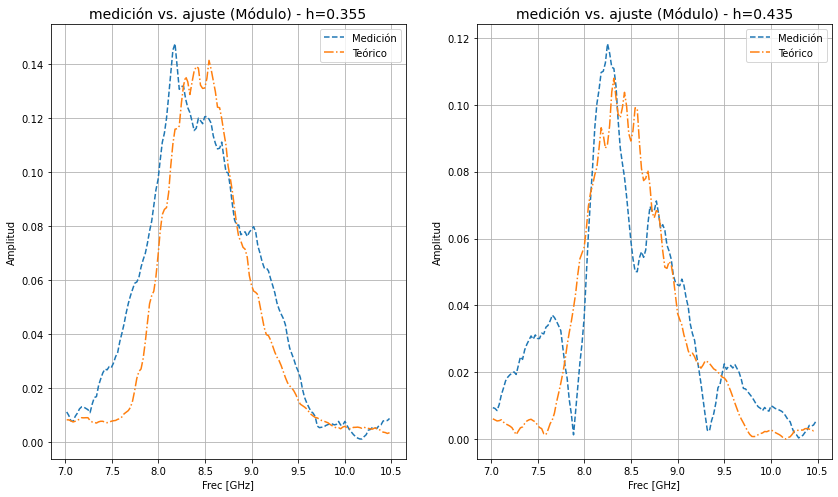

In [14]:
#grafico para diferentes alturas
fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
for i1 in range(2):
    #for i2 in range(2):
    i0 = int(i1)
    # Señal optima:
    Rf_opt = Rf_2(EP1_opt[i0],EP2_opt[i0],D_opt[i0],0,f,RMS1_opt[i0],RMS2_opt[i0]) 
    S2_opt = S1B[i0,:]*Rf_opt
    ax[i1].plot(f,np.abs(S2[i0,:]),'--',label='Medición')
    ax[i1].plot(f,np.abs(S2_opt),'-.',label='Teórico')
    ax[i1].grid('on')
    ax[i1].legend(loc="best",fontsize=10)
    ax[i1].set_xlabel('Frec [GHz]')
    ax[i1].set_ylabel('Amplitud')
    ax[i1].set_title( 'medición vs. ajuste (Módulo) - h='+str(h1[i0]), fontsize=14) #, fontstyle='normal')

plt.savefig(os.path.join('graficos','S2_rugoso_agostoB.png'))

SI A LA MEDICION TEORICA LE PONGO UNA AMPLITUD DE 1.5 ME DA ALGO RE PARECIDO!!

IndexError: index 2 is out of bounds for axis 0 with size 2

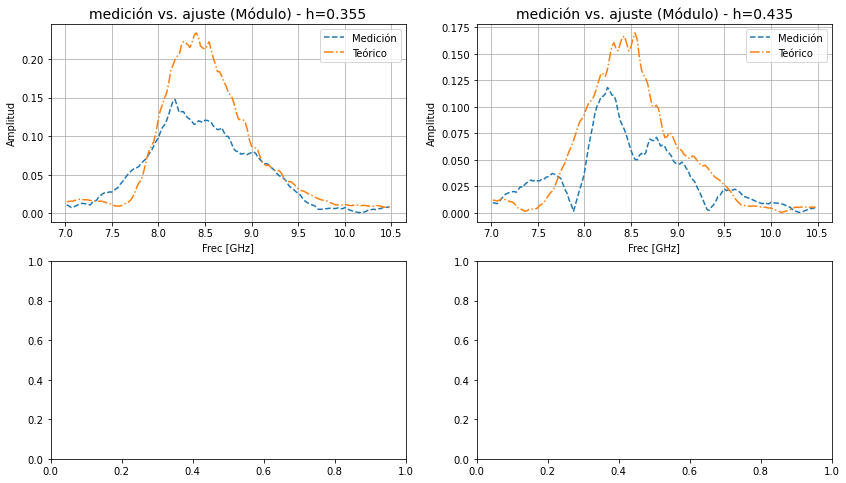

In [15]:
fig , ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
for i1 in range(2):
    for i2 in range(2):
        i0 = int(2*i1+i2)
        # Señal optima:
        Rf_opt = Rf_2(EP1_opt[i0],EP2_opt[i0],D_opt[i0],0,f,RMS1_opt[i0],RMS2_opt[i0]) 
        S2_opt = S1[i0,:]*Rf_opt
        ax[i1,i2].plot(f,np.abs(S2[i0,:]),'--',label='Medición')
        ax[i1,i2].plot(f,1.5*np.abs(S2_opt),'-.',label='Teórico')
        ax[i1,i2].grid('on')
        ax[i1,i2].legend(loc="best",fontsize=10)
        ax[i1,i2].set_xlabel('Frec [GHz]')
        ax[i1,i2].set_ylabel('Amplitud')
        ax[i1,i2].set_title( 'medición vs. ajuste (Módulo) - h='+str(h1[i0]), fontsize=14) #, fontstyle='normal')


In [ ]:
with open('Mediciones/id_opt_agostoB.pkl','rb') as kkk:
    Ag = pickle.load(kkk)
print(Ag.keys())


FileNotFoundError: [Errno 2] No such file or directory: 'Mediciones/id_opt_agostoB.pkl'